In [1]:
import numpy as np
import pandas as pd
import matplotlib
import pmdarima as pm
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import warnings
import itertools
import multi_prophet
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from math import *
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [2]:
df1 = pd.read_csv("demand_CLUB - MANCHESTER UNITED_11.csv")
df1

,Unnamed: 0,Order_Week,year,week,Article Article Description,Date,Demand Qty_final
0,0,201837,2018,37,MUFC A JSY,2018-09-10,823
1,1,201838,2018,38,MUFC A JSY,2018-09-17,257
2,2,201839,2018,39,MUFC A JSY,2018-09-24,132
3,3,201840,2018,40,MUFC A JSY,2018-10-01,87
4,4,201841,2018,41,MUFC A JSY,2018-10-08,48
...,...,...,...,...,...,...,...
156,156,202137,2021,37,MUFC A JSY,2021-09-13,63
157,157,202138,2021,38,MUFC A JSY,2021-09-20,31
158,158,202139,2021,39,MUFC A JSY,2021-09-27,163
159,159,202140,2021,40,MUFC A JSY,2021-10-04,330


In [3]:
gt = pd.read_csv("Trends_data.csv")
gt.columns = ['Trends_Date','Trends']

In [4]:
final = pd.concat([df1,gt],axis = 1)
#final = final[['Date','Demand Qty_final','Trends']]
final

,Unnamed: 0,Order_Week,year,week,Article Article Description,Date,Demand Qty_final,Trends_Date,Trends
0,0,201837,2018,37,MUFC A JSY,2018-09-10,823,09-09-2018,6
1,1,201838,2018,38,MUFC A JSY,2018-09-17,257,16-09-2018,39
2,2,201839,2018,39,MUFC A JSY,2018-09-24,132,23-09-2018,19
3,3,201840,2018,40,MUFC A JSY,2018-10-01,87,30-09-2018,13
4,4,201841,2018,41,MUFC A JSY,2018-10-08,48,07-10-2018,13
...,...,...,...,...,...,...,...,...,...
156,156,202137,2021,37,MUFC A JSY,2021-09-13,63,12-09-2021,95
157,157,202138,2021,38,MUFC A JSY,2021-09-20,31,19-09-2021,46
158,158,202139,2021,39,MUFC A JSY,2021-09-27,163,26-09-2021,52
159,159,202140,2021,40,MUFC A JSY,2021-10-04,330,03-10-2021,39


In [5]:
df = final[['Date','Demand Qty_final','Trends']]
df

,Date,Demand Qty_final,Trends
0,2018-09-10,823,6
1,2018-09-17,257,39
2,2018-09-24,132,19
3,2018-10-01,87,13
4,2018-10-08,48,13
...,...,...,...
156,2021-09-13,63,95
157,2021-09-20,31,46
158,2021-09-27,163,52
159,2021-10-04,330,39


In [6]:
df['Date']=pd.to_datetime(df['Date'])

df = df.set_index('Date')

df1 = df.copy()
df


,Demand Qty_final,Trends
Date,,
2018-09-10,823,6
2018-09-17,257,39
2018-09-24,132,19
2018-10-01,87,13
2018-10-08,48,13
...,...,...
2021-09-13,63,95
2021-09-20,31,46
2021-09-27,163,52


In [7]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")


In [8]:
for name, column in df.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Demand Qty_final" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4.0219
 No. Lags Chosen       = 4
 Critical value 1%     = -3.473
 Critical value 5%     = -2.88
 Critical value 10%    = -2.577
 => P-Value = 0.0013. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Trends" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.5914
 No. Lags Chosen       = 5
 Critical value 1%     = -3.473
 Critical value 5%     = -2.88
 Critical value 10%    = -2.577
 => P-Value = 0.4879. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.




In [8]:
train = df[:'2020-10-08'] # dataset to train
val = df['2020-08-17':] # last X months for test  
predict_date = len(df) - len(df[:'2020-08-17']) 
predict_date

60

In [10]:
train.columns

Index(['Demand Qty_final', 'Trends'], dtype='object')

In [13]:
val.columns

Index(['Demand Qty_final', 'Trends'], dtype='object')

In [18]:
import itertools

def sarima_grid_search(y,seasonal_period):
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2],seasonal_period) for x in list(itertools.product(p, d, q))]
    
    mini = float('+inf')
    
    
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(y,exog = train['Trends'],
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                results = mod.fit()
                
                if results.aic < mini:
                    mini = results.aic
                    param_mini = param
                    param_seasonal_mini = param_seasonal

#                 print('SARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
            except:
                continue
    print('The set of parameters with the minimum AIC is: SARIMA{}x{} - AIC:{}'.format(param_mini, param_seasonal_mini, mini))
sarima_grid_search(train['Demand Qty_final'],52)

The set of parameters with the minimum AIC is: SARIMA(0, 1, 0)x(0, 1, 1, 52) - AIC:-9.593793977744156


In [15]:
# Call this function after pick the right(p,d,q) for SARIMA based on AIC               

def sarima_eva(y,order,seasonal_order,seasonal_period,pred_date,y_to_test):
    # fit the model 
    mod = sm.tsa.statespace.SARIMAX(y,exog = train['Trends'],
                                order=order,
                                seasonal_order=seasonal_order,
                                #enforce_stationarity=False,
                                enforce_invertibility=False)

    results = mod.fit()
    print(results.summary().tables[1])
    
    results.plot_diagnostics(figsize=(16, 8))
    plt.show()
    
    # The dynamic=False argument ensures that we produce one-step ahead forecasts, 
    # meaning that forecasts at each point are generated using the full history up to that point.
    
    
#     pred = results.get_prediction(start=pred_date, dynamic=False,exog = val['Trends'])
#     pred_ci = pred.conf_int()
#     y_forecasted = pred.predicted_mean
#     mse = ((y_forecasted - y_to_test) ** 2).mean()
#     print('The Root Mean Squared Error of SARIMA with season_length={} and dynamic = False {}'.format(seasonal_period,round(np.sqrt(mse), 2)))

    
#     y_forecasted = pred.predicted_mean
#     mae = mean_absolute_error(y_forecasted,y_to_test)
#     print('mae error is',mae)
#     print('R2 error is',r2_score(y_forecasted,y_to_test))
#     mape = np.mean(np.abs(( y_to_test- y_forecasted)/y_to_test))*100
#     print('MAPE error is',mape)
    
#     ax = y.plot(label='observed')
#     y_forecasted.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
#     ax.fill_between(pred_ci.index,
#                     pred_ci.iloc[:, 0],
#                     pred_ci.iloc[:, 1], color='k', alpha=.2)

#     ax.set_xlabel('Date')
#     ax.set_ylabel('Demand Quantity')
#     plt.legend()
#     plt.show()
    
   
    
#     # A better representation of our true predictive power can be obtained using dynamic forecasts. 
#     # In this case, we only use information from the time series up to a certain point, 
#     # and after that, forecasts are generated using values from previous forecasted time points.
    
#     pred_dynamic = results.get_prediction(start=pred_date, dynamic=True, full_results=True,exog = val['Trends'])
#     pred_dynamic_ci = pred_dynamic.conf_int()
#     y_forecasted_dynamic = pred_dynamic.predicted_mean
#     mse_dynamic = ((y_forecasted_dynamic - y_to_test) ** 2).mean()
#     print('The Root Mean Squared Error of SARIMA with season_length={} and dynamic = True {}'.format(seasonal_period,round(np.sqrt(mse_dynamic), 2)))

#     ax = y.plot(label='observed')
#     y_forecasted_dynamic.plot(label='Dynamic Forecast', ax=ax,figsize=(14, 7))
#     ax.fill_between(pred_dynamic_ci.index,
#                     pred_dynamic_ci.iloc[:, 0],
#                     pred_dynamic_ci.iloc[:, 1], color='k', alpha=.2)
   

#     ax.set_xlabel('Date')
#     ax.set_ylabel('Demand Quantity')

#     plt.legend()
#     plt.show()
    
#     return (results)

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Trends        -0.7294      0.626     -1.164      0.244      -1.957       0.498
ma.S.L52      -0.1240      1.537     -0.081      0.936      -3.136       2.888
sigma2      1.385e+04   5437.229      2.547      0.011    3189.487    2.45e+04


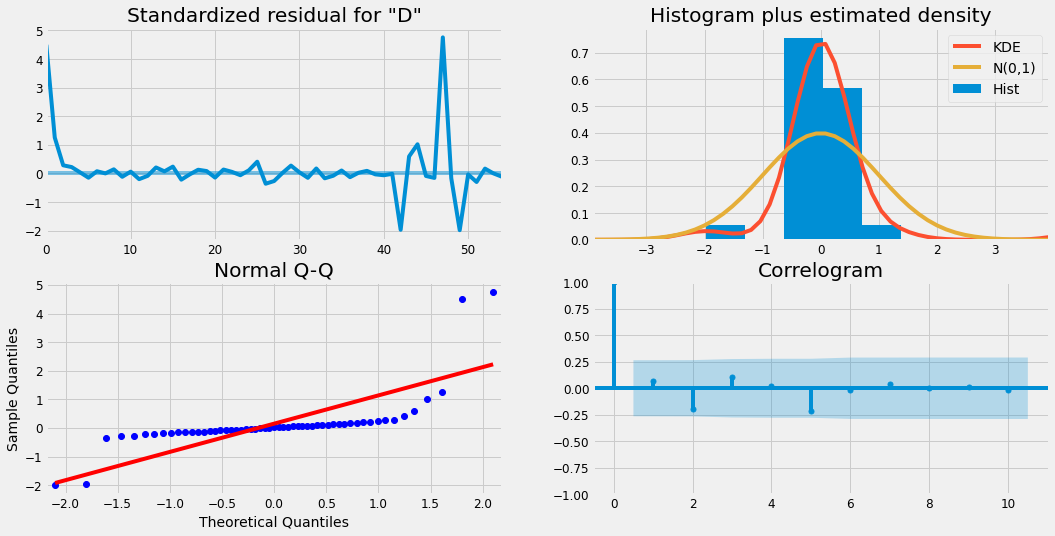

The Root Mean Squared Error of SARIMA with season_length=52 and dynamic = False 2020-08-17 00:00:00   NaN
2020-08-24 00:00:00   NaN
2020-08-31 00:00:00   NaN
2020-09-07 00:00:00   NaN
2020-09-14 00:00:00   NaN
2020-09-21 00:00:00   NaN
2020-09-28 00:00:00   NaN
2020-10-05 00:00:00   NaN
Demand Qty_final      NaN
Trends                NaN
dtype: float64


ValueError: Found input variables with inconsistent numbers of samples: [8, 61]

In [17]:
model = sarima_eva(train['Demand Qty_final'],(0, 1, 0),(0, 1, 1, 52),52,'2020-08-17',val)#0, 1, 0)x(0, 1, 1, 52

In [9]:
tes = val.drop('Demand Qty_final',axis = 1)
tes.tail()
#tes.head()

,Trends
Date,
2021-09-13,95
2021-09-20,46
2021-09-27,52
2021-10-04,39
2021-10-11,36


In [ ]:

import itertools 
from sklearn.metrics import mean_squared_error
p = d = q = range(0,3) 
pdq = list(itertools.product(p, d, q)) 
seasonal_pdq = [(x[0], x[1], x[2],52) for x in list(itertools.product(p, d, q))]
#print(seasonal_pdq)

params = [] 
params_s = [] 
aics = [] 
mses = [] 
cnt = 0 
for param in pdq: 
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train['Demand Qty_final'],
                                        order=param,
                                        exog =  train['Trends'] ,
                                        seasonal_order=param_seasonal,
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)

            results = mod.fit()


            pred = results.get_prediction(start = pd.to_datetime('2020-08-17'),
                                  end = pd.to_datetime('2021-10-11'),exog=val['Trends'])

            params.append(param)
            params_s.append(param_seasonal)
            mini = results.aic
            aics.append(results.aic)
            mses.append(mean_squared_error(tes,pred.predicted_mean[1:]))

        except:
            
            continue
            
#print('SARIMAX{}x{} - AIC:{} - MSE:{}'.format(param,param_seasonal,results.aic,mses[-1]))
print('The set of parameters with the minimum AIC is: SARIMA{}x{} - AIC:{}'.format(param, param_seasonal, mini))
            
            



[(0, 0, 0, 52), (0, 0, 1, 52), (0, 0, 2, 52), (0, 1, 0, 52), (0, 1, 1, 52), (0, 1, 2, 52), (0, 2, 0, 52), (0, 2, 1, 52), (0, 2, 2, 52), (1, 0, 0, 52), (1, 0, 1, 52), (1, 0, 2, 52), (1, 1, 0, 52), (1, 1, 1, 52), (1, 1, 2, 52), (1, 2, 0, 52), (1, 2, 1, 52), (1, 2, 2, 52), (2, 0, 0, 52), (2, 0, 1, 52), (2, 0, 2, 52), (2, 1, 0, 52), (2, 1, 1, 52), (2, 1, 2, 52), (2, 2, 0, 52), (2, 2, 1, 52), (2, 2, 2, 52)]


NameError: name 'fitted_series' is not defined

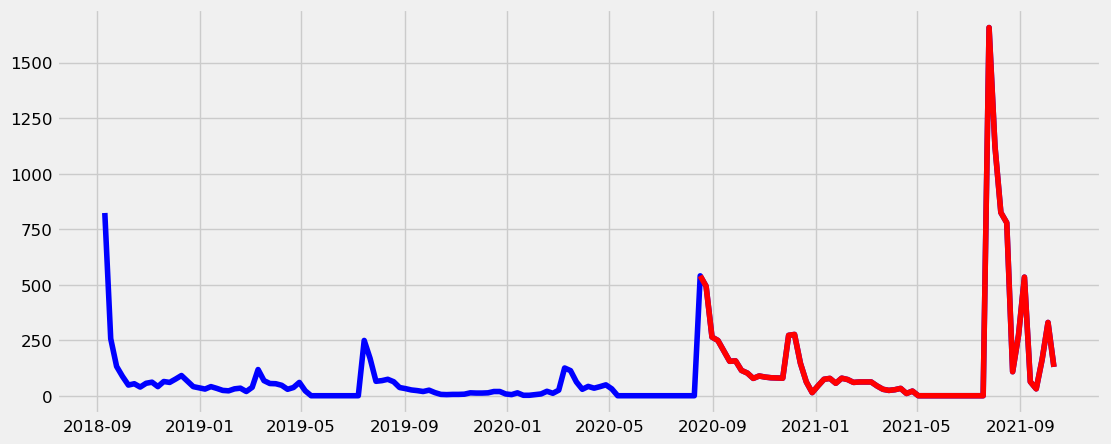

In [12]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(df['Demand Qty_final'],label = 'train',color = 'blue')
plt.plot(val['Demand Qty_final'], label='test',color = 'red')
plt.plot(fitted_series, color='darkgreen',label = 'forecast')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("forecast vs actuals")
plt.show()

In [ ]:
from statsmodels.tsa.stattools import acf
from sklearn.metrics import mean_squared_error

def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mse = mean_squared_error(actual, forecast)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    return({'mape':mape, 'mae': mae, 
            'mse': mse, 'rmse':rmse, 
            'corr':corr})

forecast_accuracy(fitted_series.values, val['Demand Qty_final'].values)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
# transform data
tr = scaler.fit_transform(train)
ts = scaler.fit_transform(val)
ts



In [ ]:
tr = pd.DataFrame(tr,columns = train.columns,index = train.index)
ts = pd.DataFrame(ts,columns = val.columns,index = val.index)
tr.head(),tr.isnull().sum(),ts.isnull().sum()

In [ ]:
mod_sc = pm.auto_arima(tr['Demand Qty_final'], exogenous=tr[['Trends']],#m=52,seasonal = True,trace  =True)
                           start_p=0, start_q=0,n_jobs = 100,
                           max_p=4, max_q=4, m=52,
                           start_P=0, seasonal=True,
                           d=None, D=None, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

mod_sc.summary()

In [ ]:
fit, conf  = mod_sc.predict(n_periods=len(ts),exogenous=np.tile(ts['Trends'].values, 1).reshape(-1,1), 
                                    return_conf_int=True,apha = 0.05)
fit

In [ ]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(tr['Demand Qty_final'],label = 'train',color = 'blue')
plt.plot(ts['Demand Qty_final'], label='test',color = 'red')
plt.plot(fit_series, color='darkgreen',label = 'forecast')
plt.fill_between(lower_bound.index, 
                 lower_bound, 
                 upper_bound, 
                 color='k', alpha=.15)

plt.title("forecast vs actuals")
plt.show()

In [ ]:
conf_sca = pd.DataFrame(scaler.inverse_transform(conf),columns = ['lower_bound','upper_bound'])
conf_sca

In [ ]:
dup = pd.concat([fit_series,ts['Demand Qty_final']],axis = 1)
dup.columns = ['demand_pred','demand_dup']
dup.head()

In [ ]:
con_sca = pd.DataFrame(scaler.inverse_transform(dup),columns = dup.columns)
con_sca = con_sca[['demand_pred']]
con_sca

In [ ]:
val.head()

In [ ]:
from statsmodels.tsa.stattools import acf
from sklearn.metrics import mean_squared_error
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE            # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mse = mean_squared_error(actual, forecast)
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    #corr = np.corrcoef(forecast, actual)[0,1]   # corr
    return({'mape':mape,'mae': mae, 
            'mse': mse, 'rmse':rmse})

forecast_accuracy(con_sca.values, val['Demand Qty_final'].values)

In [ ]:
{'mape': inf,
 'mae': 152.06635452606324,
 'mse': 97381.79144005523,
 'rmse': 312.06055732830964,
 'corr': -0.19215569047542483}